In [7]:
import pandas as pd

In [ ]:
pixels = pd.read_csv("flattened_images.csv")
train_metadata = pd.read_csv("train/train_metadata.csv")
merged_df = pixels.merge(train_metadata, on='image_path')
hog_pca = pd.read_csv("train/Features/hog_pca.csv")
color_hist = pd.read_csv("train/Features/color_histogram.csv")
additional_features = pd.read_csv("train/Features/additional_features.csv")

merged_df = pixels.merge(train_metadata, on='image_path')


merged_df = merged_df.merge(hog_pca, on='image_path')
merged_df = merged_df.merge(color_hist, on='image_path')
merged_df = merged_df.merge(additional_features, on='image_path')





In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset first
train_df, test_df = train_test_split(
    merged_df, 
    test_size=0.2, 
    stratify=merged_df['ClassId'], 
    random_state=42
)

from sklearn.utils import resample


max_count = train_df['ClassId'].value_counts().max()


bootstrapped_train_dfs = []

for class_id, group in train_df.groupby('ClassId'):
    bootstrapped_group = resample(
        group,
        replace=True,       
        n_samples=max_count,       
        random_state=42
    )
    bootstrapped_train_dfs.append(bootstrapped_group)


train_df = pd.concat(bootstrapped_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

features = train_df.columns.difference(['image_path', 'ClassId'])


scaler = StandardScaler()


scaler.fit(train_df[features])

train_df[features] = train_df[features].astype(float)
test_df[features] = test_df[features].astype(float)


train_df.loc[:, features] = scaler.transform(train_df[features])
test_df.loc[:, features] = scaler.transform(test_df[features])


X_train = train_df.drop(['image_path', 'ClassId'], axis=1).values
y_train = train_df['ClassId'].values

X_test = test_df.drop(['image_path', 'ClassId'], axis=1).values
y_test = test_df['ClassId'].values

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


clf = MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, random_state=42)


clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8479


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd


cm = confusion_matrix(y_test, y_pred)


num_classes = cm.shape[0]


misclassified_counts = cm.sum(axis=1) - np.diag(cm)

df_misclass = pd.DataFrame({
    'Class': range(num_classes),  
    'Misclassified Count': misclassified_counts,
    'Total Samples': cm.sum(axis=1),
    'Misclassification Rate': misclassified_counts / cm.sum(axis=1)
})


df_misclass_sorted = df_misclass.sort_values(by='Misclassification Rate', ascending=False)
display(df_misclass_sorted.head(10))  

,Class,Misclassified Count,Total Samples,Misclassification Rate
19,19,3,6,0.500000
29,29,3,7,0.428571
0,0,2,6,0.333333
21,21,3,9,0.333333
28,28,5,15,0.333333
7,7,12,40,0.300000
23,23,4,14,0.285714
32,32,2,7,0.285714
2,2,18,63,0.285714
3,3,11,39,0.282051


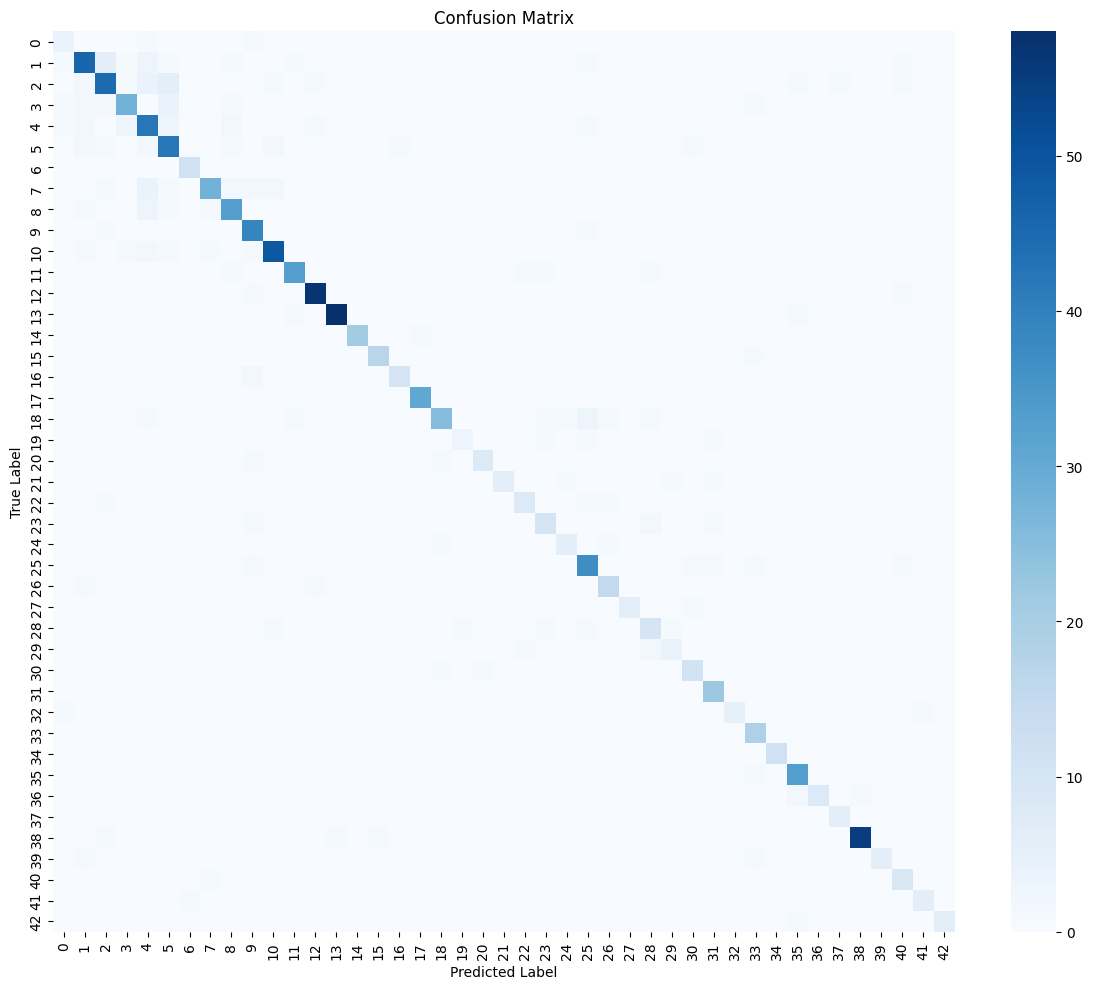

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')  

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()